In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline 
import os 
import shap
from sklearn.preprocessing import MaxAbsScaler
import random

Prepare the datasets

In [ ]:
# load into a Pandas dataframe
dataframe = pd.read_csv("dataset2.csv")

# only focus on PREVAC right now
dataframe = dataframe[dataframe['cycle_type'] == 'PREVAC']
dataframe.drop("cycle_type", axis=1, inplace=True)

print(dataframe.shape)
dataframe.head()

# split the data into a training and validation set
val_dataframe = dataframe.sample(frac=0.2, random_state=7491)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation for classification NN"
    % (len(train_dataframe), len(val_dataframe))
)

Analyze the imbalance in the dataset


In [ ]:
counts = np.bincount(train_dataframe["FSR_Required"])
val_counts = np.bincount(val_dataframe["FSR_Required"])

print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / train_dataframe["FSR_Required"].shape[0]
    )
)

val_counts = np.bincount(val_dataframe["FSR_Required"])
print(
    "Number of positive samples in validation data: {} ({:.2f}% of total)".format(
        val_counts[1], 100 * float(val_counts[1]) / val_dataframe["FSR_Required"].shape[0]
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Normalize the datasets using AbsMax. This is crucial

In [ ]:
# normalize training, validation
abs_scaler = MaxAbsScaler()
abs_scaler.fit(train_dataframe)
train_scaled = abs_scaler.transform(train_dataframe)
train_scaled = pd.DataFrame(train_scaled, columns=train_dataframe.columns)

MAX_ABS_ = abs_scaler.max_abs_
print(f"The max absolute normalization factor for this dataset is {MAX_ABS_}")

val_scaled = abs_scaler.transform(val_dataframe)
val_scaled = pd.DataFrame(val_scaled, columns=val_dataframe.columns)


Define metrics specifically for imbalanced input cases like ours.


In [ ]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

Construct the model

In [ ]:
# apply weights to alleviate the effects of imbalanced inputs
class_weights = {0: weight_for_0, 1: weight_for_1}

X_train = train_dataframe.iloc[:, :-1].values
y_train = train_dataframe.iloc[:,-1].values
X_val = val_dataframe.iloc[:, :-1].values
y_val = val_dataframe.iloc[:,-1].values

input = tf.keras.Input(X_train.shape[1])
x = keras.layers.Dense(32, activation="relu")(input)
x = keras.layers.Dropout(0.3)(x)
predictions = keras.layers.Dense(1, activation="sigmoid")(x)

MLP_model = keras.Model(inputs=input, outputs=predictions)
MLP_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=metrics)


MLP_model.summary()

Train the model

In [ ]:
MLP_model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    verbose=2, # for the progress bar
    class_weight=class_weights,
    batch_size=16
)

Save the model to MLP.h5

In [ ]:
MLP_model.save('MLP.h5')

Naive approach to explain the output

In [ ]:
# Takes a DataFrame sample and a trained model
# Returns the binary_crossentropy between the predicted value and 0 which is a healthy cycle
def predict(sample, model):
    prediction = model.predict(sample)
    loss = tf.keras.losses.binary_crossentropy(0, prediction)
    return loss.numpy()[0]

In [181]:
# use a random cycle
r = random.randint(0, len(X_val))
sample = X_val[r].reshape(1,-1)
loss = predict(sample, model=keras.models.load_model('MLP.h5'))
print(f"This particular cycle is {loss * 100}% likely to be unhealthy")

1/1 [==============================] - 0s 94ms/step
This particular cycle is 50.73078274726868% likely to be unhealthy


SHAP approach for determining a baseline then evaluate the output based on baseline

In [174]:
explainer = shap.DeepExplainer(MLP_model, X_train)
# get random sample for analysis
r = random.randint(0, len(X_val))
sample = X_val[r].reshape(1,-1)
shap_values = explainer.shap_values(sample)

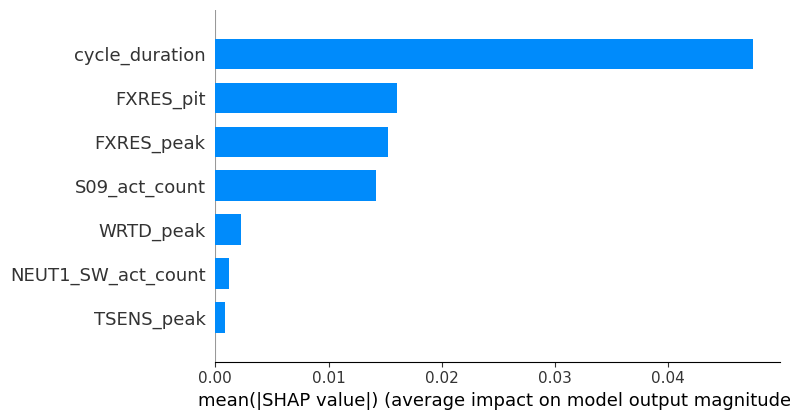

In [175]:
# Feature contribution to the output
shap.summary_plot(shap_values[0], plot_type='bar', feature_names=train_dataframe.iloc[:, :-1].columns, max_display=7)

SHAP local interpretation

Use a waterfall plot to visualize how each feature contributes to the output of the model given an input

f(x) represents the predicted valueof the model given input x

E[f(x)] represents the expected value of the target variable, in other words, the mean of all predictions

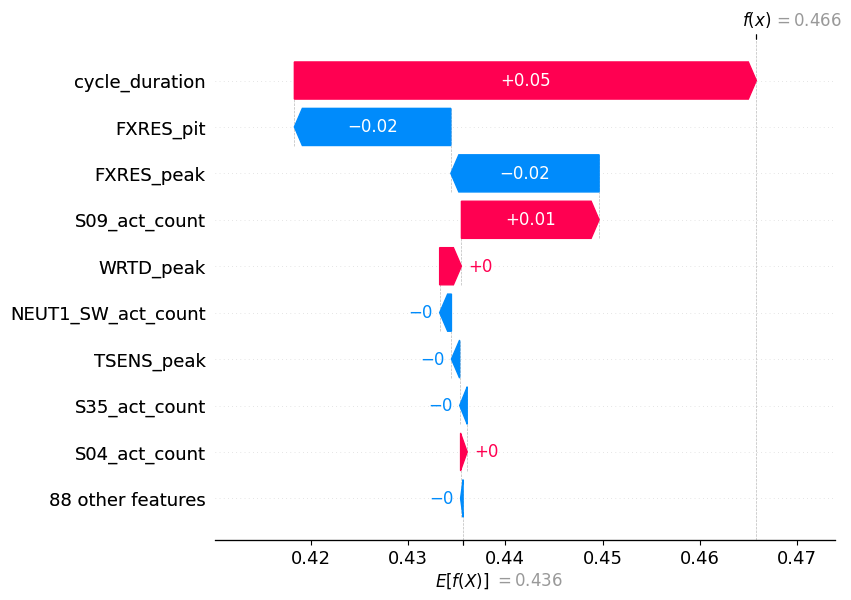

In [176]:
shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][0], feature_names=train_dataframe.iloc[:, :-1].columns)

In [191]:
# define the baseline of our predicted value as the threshold
threshold = explainer.expected_value[0]
prediction = MLP_model.predict(sample)
likelihood = (prediction - threshold)/threshold
print(f"This particular cycle is {str(likelihood * 100)[12:20]}% more likely to be unhealthy comparing to baseline ")

1/1 [==============================] - 0s 27ms/step


This particular cycle is -8.67063% more likely to be unhealthy comparing to baseline 
